<a href="https://colab.research.google.com/github/codeNina42/online-fraud-detection/blob/main/online_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Colab!

In [ ]:
#@title Install & imports (Colab-safe)
!pip -q install -U imbalanced-learn xgboost

import os, sys, json, math, warnings, itertools
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve, roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import joblib

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pd.set_option("display.max_columns", 200)


In [20]:
#@title Choose how you'll provide the CSV
SOURCE = "Upload"  #@param ["Upload", "Google Drive (mount)", "Direct path (already in /content)"]

CSV_PATH = ""  #@param {type:"string"}
SAMPLE_FRAC = 1.0  #@param {type:"number"}
SAMPLE_FRAC = float(SAMPLE_FRAC)

df = None

if SOURCE == "Upload":
    from google.colab import files
    up = files.upload()
    if not up:
        raise SystemExit("No file uploaded.")
    CSV_PATH = list(up.keys())[0]
    df = pd.read_csv(CSV_PATH)

elif SOURCE == "Google Drive (mount)":
    from google.colab import drive
    drive.mount('/content/drive')
    if not CSV_PATH:
        raise SystemExit("Set CSV_PATH to your file, e.g. '/content/drive/MyDrive/data/payments.csv'")
    df = pd.read_csv(CSV_PATH)

else:  # Direct path
    if not CSV_PATH:
        raise SystemExit("Set CSV_PATH to a CSV in /content.")
    df = pd.read_csv(CSV_PATH)

# Optional sampling for huge files (keeps class ratio roughly stable)
if SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_SEED)

print("Shape:", df.shape)
display(df.head(3))


Saving fraud_detection_short.csv to fraud_detection_short (1).csv
Shape: (60, 13)


,transaction_id,hour,type,merchant_category,country,isInternational,amount,device_score,attempts_24h,prev_fraud_user,isProxyIP,velocity_1h,isFraud
0,TXHDPITCU8,2,PAYMENT,groceries,NZ,1,700.94,0.676,1,0,0,3,0
1,TXFEL3GUXN,18,CASH_OUT,digital,BD,0,271.58,0.593,2,1,0,0,1
2,TXNIG2CKRM,6,TRANSFER,groceries,BD,0,678.96,0.923,0,0,0,4,0


In [21]:
#@title Auto-detect label column (edit if wrong)
# Heuristics for common fraud labels
possible_labels = ["isFraud","is_fraud","fraud","Fraud","Class","target","label","Label"]
label_col = next((c for c in possible_labels if c in df.columns), None)

if label_col is None:
    # 🔧 Set your label here if not detected:
    label_col = "isFraud"  #@param {type:"string"}
    if label_col not in df.columns:
        raise SystemExit(f"Label column '{label_col}' not found. Fix it and re-run.")

# Normalize label to {0,1}
if df[label_col].dtype.kind in "OUSb":
    df[label_col] = df[label_col].astype(str).str.strip().str.lower().map({"1":1,"true":1,"yes":1,"fraud":1}).fillna(0).astype(int)

# Drop obvious ID/leak columns if present (safe no-ops if missing)
drop_maybe = [
    "nameOrig","nameDest","oldbalanceOrg","newbalanceOrig","oldbalanceDest",
    "newbalanceDest","step", "isFlaggedFraud", "transaction_id", "id"
]
df = df.drop(columns=[c for c in drop_maybe if c in df.columns], errors="ignore")

# Remove perfect duplicates
df = df.drop_duplicates().reset_index(drop=True)

print("Label column:", label_col)
print(df[label_col].value_counts(normalize=True).rename("ratio"))


Label column: isFraud
isFraud
0    0.683333
1    0.316667
Name: ratio, dtype: float64


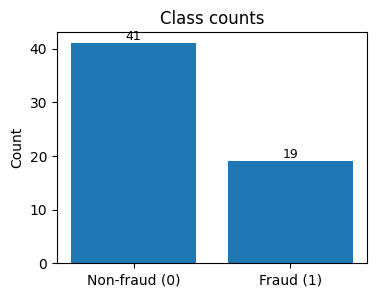

In [22]:
#@title Class balance
counts = df[label_col].value_counts().sort_index()
plt.figure(figsize=(4,3))
plt.bar(["Non-fraud (0)","Fraud (1)"], counts.values)
plt.title("Class counts"); plt.ylabel("Count")
for i, v in enumerate(counts.values): plt.text(i, v, str(v), ha='center', va='bottom', fontsize=9)
plt.show()


In [23]:
#@title Split & build preprocessing
X = df.drop(columns=[label_col])
y = df[label_col].astype(int)

cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler(with_mean=False))  # with_mean=False is sparse-safe
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (48, 11) Test: (12, 11)


In [24]:
#@title Imbalance handling
USE_SMOTE = True  #@param {type:"boolean"}

# scale_pos_weight for XGB if we don't SMOTE
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / max(1, pos)) if pos > 0 else 1.0

print(f"Positives in train: {pos} of {len(y_train)} (pos_rate={pos/len(y_train):.4f})")
print("SMOTE:", USE_SMOTE, "| scale_pos_weight for XGB:", round(scale_pos_weight,2))


Positives in train: 15 of 48 (pos_rate=0.3125)
SMOTE: True | scale_pos_weight for XGB: 2.2


In [26]:
#@title Define models like the article (LR, RF, XGB)
models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None),
    "RF": RandomForestClassifier(
        n_estimators=400, max_depth=None, n_jobs=-1, random_state=RANDOM_SEED,
        class_weight="balanced_subsample"
    ),
    "XGB": XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.06, subsample=0.9,
        colsample_bytree=0.9, tree_method="hist", random_state=RANDOM_SEED,
        eval_metric="logloss", scale_pos_weight=None if USE_SMOTE else scale_pos_weight
    )
}



==== LogReg @ 0.50 threshold ====
              precision    recall  f1-score   support

           0     0.7273    1.0000    0.8421         8
           1     1.0000    0.2500    0.4000         4

    accuracy                         0.7500        12
   macro avg     0.8636    0.6250    0.6211        12
weighted avg     0.8182    0.7500    0.6947        12

Confusion Matrix
        Pred 0  Pred 1
True 0       8       0
True 1       3       1
TN=8 FP=0 FN=3 TP=1


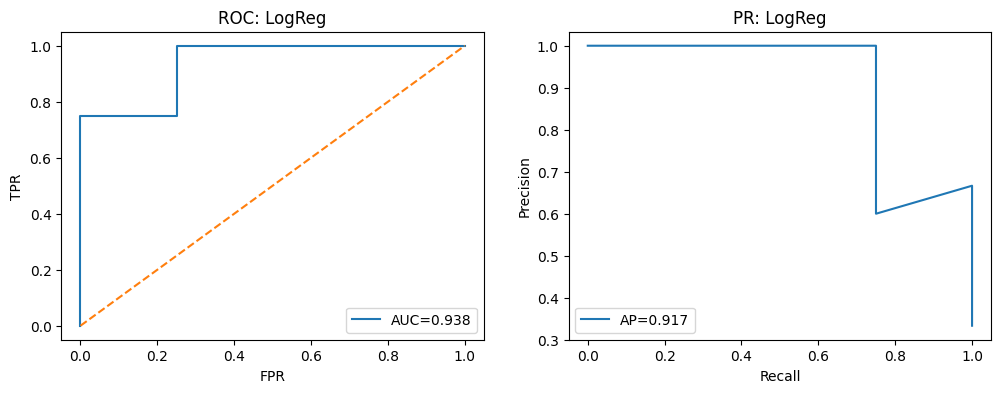


==== RF @ 0.50 threshold ====
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889         8
           1     1.0000    0.5000    0.6667         4

    accuracy                         0.8333        12
   macro avg     0.9000    0.7500    0.7778        12
weighted avg     0.8667    0.8333    0.8148        12

Confusion Matrix
        Pred 0  Pred 1
True 0       8       0
True 1       2       2
TN=8 FP=0 FN=2 TP=2


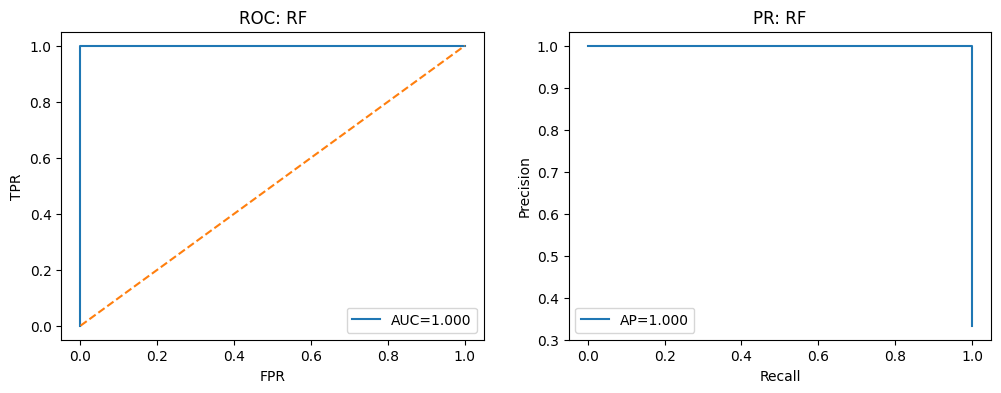


==== XGB @ 0.50 threshold ====
              precision    recall  f1-score   support

           0     0.7273    1.0000    0.8421         8
           1     1.0000    0.2500    0.4000         4

    accuracy                         0.7500        12
   macro avg     0.8636    0.6250    0.6211        12
weighted avg     0.8182    0.7500    0.6947        12

Confusion Matrix
        Pred 0  Pred 1
True 0       8       0
True 1       3       1
TN=8 FP=0 FN=3 TP=1


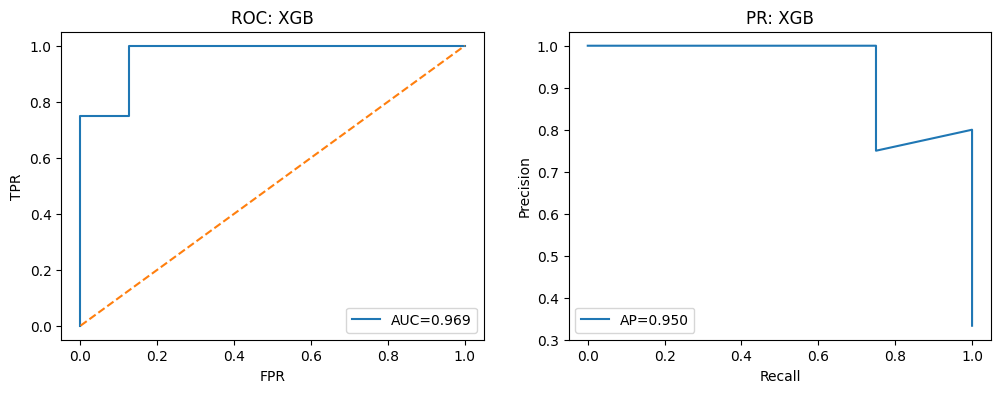

,model,roc_auc,ap
0,LogReg,0.9375,0.9167
1,RF,1.0000,1.0000
2,XGB,0.9688,0.9500


In [27]:
#@title Fit/eval helpers (fixed SMOTE + safe fallback)
from imblearn.over_sampling import SMOTE, RandomOverSampler
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve, roc_curve
)
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

def plot_roc_pr(y_true, proba, title=""):
    fpr, tpr, _ = roc_curve(y_true, proba)
    prec, rec, _ = precision_recall_curve(y_true, proba)
    auc_roc = roc_auc_score(y_true, proba)
    ap = average_precision_score(y_true, proba)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.plot(fpr, tpr, label=f"AUC={auc_roc:.3f}"); plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC: {title}"); plt.legend(loc="lower right")

    plt.subplot(1,2,2); plt.plot(rec, prec, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR: {title}"); plt.legend(loc="lower left")
    plt.show()
    return {"roc_auc": auc_roc, "ap": ap}

def print_confmat(y_true, y_pred, title=""):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    print(title)
    print(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))
    print(f"TN={tn} FP={fp} FN={fn} TP={tp}")

def threshold_tune(y_true, proba, beta=2.0):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    eps = 1e-12
    fbeta = (1+beta**2) * (prec*rec) / np.clip(beta**2*prec + rec, eps, None)
    idx = np.nanargmax(fbeta)
    best_thr = 0.5 if idx >= len(thr) else thr[idx]
    return best_thr, prec[idx], rec[idx], fbeta[idx]

def make_sampler(y, use_smote=True, random_state=42):
    if not use_smote:
        return None
    pos = int(np.sum(y))
    if pos < 2:
        print("⚠️ Too few positives for SMOTE; using RandomOverSampler.")
        return RandomOverSampler(random_state=random_state)
    # SMOTE needs k_neighbors <= positives-1
    k = min(5, max(1, pos - 1))
    return SMOTE(random_state=random_state, k_neighbors=k)  # ← no n_jobs

results = {}

for name, clf in models.items():
    sampler = make_sampler(y_train, USE_SMOTE, RANDOM_SEED)

    if sampler is not None:
        pipe = ImbPipeline(steps=[
            ("prep", preprocess),
            ("resample", sampler),
            ("clf", clf)
        ])
    else:
        pipe = Pipeline(steps=[
            ("prep", preprocess),
            ("clf", clf)
        ])

    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (proba >= 0.5).astype(int)

    print(f"\n==== {name} @ 0.50 threshold ====")
    print(classification_report(y_test, y_pred, digits=4))
    print_confmat(y_test, y_pred, title="Confusion Matrix")

    m = plot_roc_pr(y_test, proba, title=name)
    results[name] = {"model": pipe, "proba": proba, **m}

pd.DataFrame([
    {"model": k, **{kk: round(vv,4) for kk, vv in v.items() if kk in ("roc_auc","ap")}}
    for k, v in results.items()
])



In [29]:
#@title Pick best model by Average Precision (PR AUC) and tune threshold
best_name = max(results, key=lambda k: results[k]["ap"])
best = results[best_name]
print("Best by AP:", best_name, "AP=", round(best["ap"],4), "ROC AUC=", round(best["roc_auc"],4))

thr, p, r, f2 = threshold_tune(y_test, best["proba"], beta=2.0)
print(f"Best F2 threshold ~ {thr:.3f} | Precision={p:.3f} Recall={r:.3f} F2={f2:.3f}")

y_pred_tuned = (best["proba"] >= thr).astype(int)
print("\nClassification report @ tuned threshold:")
print(classification_report(y_test, y_pred_tuned, digits=4))
print_confmat(y_test, y_pred_tuned, title=f"{best_name} Confusion Matrix @ thr={thr:.3f}")


Best by AP: RF AP= 1.0 ROC AUC= 1.0
Best F2 threshold ~ 0.435 | Precision=1.000 Recall=1.000 F2=1.000

Classification report @ tuned threshold:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         8
           1     1.0000    1.0000    1.0000         4

    accuracy                         1.0000        12
   macro avg     1.0000    1.0000    1.0000        12
weighted avg     1.0000    1.0000    1.0000        12

RF Confusion Matrix @ thr=0.435
        Pred 0  Pred 1
True 0       8       0
True 1       0       4
TN=8 FP=0 FN=0 TP=4


In [30]:
#@title Save the tuned model to disk
out_path = f"/content/{best_name}_fraud_pipeline.joblib"
joblib.dump(results[best_name]["model"], out_path)
print("Saved:", out_path)

# Store chosen threshold alongside the model
meta = {"threshold": float(thr), "label_col": label_col, "feature_cols": X.columns.tolist()}
with open(f"/content/{best_name}_fraud_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved meta:", f"/content/{best_name}_fraud_meta.json")


Saved: /content/RF_fraud_pipeline.joblib
Saved meta: /content/RF_fraud_meta.json


In [31]:
#@title Inference example (replace with a real row)
loaded = joblib.load(out_path)
with open(f"/content/{best_name}_fraud_meta.json") as f:
    meta = json.load(f)

example = {c: (0 if pd.api.types.is_numeric_dtype(df[c]) else "NA") for c in meta["feature_cols"]}
# 👉 Fill example with realistic values matching your schema
ex_df = pd.DataFrame([example])
proba = loaded.predict_proba(ex_df)[:,1][0]
pred  = int(proba >= meta["threshold"])
print({"fraud_proba": float(proba), "pred_label": pred, "threshold": meta["threshold"]})


{'fraud_proba': 0.165, 'pred_label': 0, 'threshold': 0.435}
